# Advanced Lane Finding

In this project, we will identify lanes in highway images and videos. To accomplish this, we use the following pipeline: 

1. Calibrate the camera using checkerboard images, and use the obtained coefficients to undistort the subsequent images. 
1. Change the perspective of the images, so that the images appear to be take form a top-down (birdseye) view. 
1. Mask the images and apply some colorspace transforms to produce a binary image indicating which pixels are lane pixels.
1. Fit 2nd order polynomials to the lanes. 

Programmatically, we accomplish that thusly:

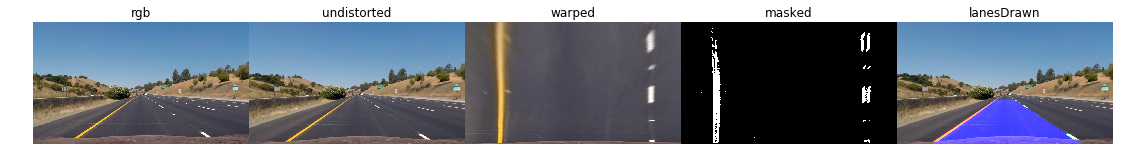

In [1]:
import cv2
import points
import calibrationParams
from undistorter import Undistorter
from warper import Warper
import masker
from lanes import LaneFinder
import matplotlib.pyplot as plt

%matplotlib inline

# Load an image
bgr = cv2.imread('test_images/straight_lines1.jpg')
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# Get the checkerboard points in 2D and 3D space from a sequence of checkerboard images 
objpoints, imgpoints = points.get()

# Compute the calibration parameters
ret, mtx, dist, rvecs, tvecs = calibrationParams.get(objpoints=objpoints, imgpoints=imgpoints, width=1280, height=720)

# Create the object which can undisort images 
undistorter = Undistorter(mtx,dist)
undistorted = undistorter.undistort(rgb)

# Create the object which can warp an image to the desired birdseye view
warper = Warper()
warped = warper.warp(undistorted)

# Mask the image to hide all of the non-lane pixels
masked = masker.mask(warped)

# Detect the lanes in the image
laneFinder = LaneFinder( undistorter=undistorter, warper=warper )
lanesDrawn = laneFinder.find(rgb)

# Show the step-by-step results
images = [  rgb ,  undistorted ,  warped ,  masked ,  lanesDrawn  ]
labels = [ 'rgb', 'undistorted', 'warped', 'masked', 'lanesDrawn' ]
graysc = [ False,         False,    False,     True,      False  ]

fig, ax = plt.subplots(1,len(images))
fig.subplots_adjust(hspace=0, wspace=0, bottom=0, left=0, top=1, right=1)
fig.set_size_inches(15,15)
for a, image, label, gray in zip( ax, images, labels, graysc ):
    if gray:
        a.imshow( image, cmap='gray' )
    else:
        a.imshow( image )
    a.set_title(label)
    a.axis("off")

In the end, we will be able to detect lanes in still images and videos, as demonstrated in the following videos:

<video width="100%" controls src="output_videos/combined.mp4" />

## Camera Calibration

To be able to compute distance and other parameters from images, we need to calibrate the camera. This means removing curvature and other abnormalities from the image so that straight lines in real life are represented as straight lines in the images. Fisheye lenses are the most common and obvious example of a situation in which a lens intentionally distorts images, but aside from high-end photography equipment, all cameras will have at least a little bit of distortion. So the first thing we need to do is to remove all of the distortions. 

To know how a camera is distorting images, we need to take pictures of points with known locations, and compare them to where they occur in the actual images. Using such data, we can essentially perform a fancy curve fit to determine how the camera is distorting images. It is particularly important to take images near the edges because they tend to be the most distorted areas, and to remove such distortions, we need to have examples of how a known pattern appears in each region of the image. 
For example, this is a picture taken from our camera before calibration:

<img width=40% src = 'camera_cal/calibration1.jpg' />

Just looking at the image, you can tell that our camera has a little bit of a fisheye effect... the lines of a checkerboard should be straight, but these lines apper to be curved, particularly near the edges. Therefore, to obtain calibration images, we printed out a checkboard, laid it flat on a surface, and took the following pictures from multiple angles and distances: 

<br/>

<div><img src="camera_cal/calibration1.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration2.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration3.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration4.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration5.jpg" width=20% style="float: left;"></div>
<div style="clear: both;"></div>
<div><img src="camera_cal/calibration6.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration7.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration8.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration9.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration10.jpg" width=20% style="float: left;"></div>
<div style="clear: both;"></div>
<div><img src="camera_cal/calibration11.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration12.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration13.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration14.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration15.jpg" width=20% style="float: left;"></div>
<div style="clear: both;"></div>
<div><img src="camera_cal/calibration16.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration17.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration18.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration19.jpg" width=20% style="float: left;"></div>
<div><img src="camera_cal/calibration20.jpg" width=20% style="float: left;"></div>
<div style="clear: both;"></div>

Ultimately, what we will be comparing are the locations of the interior checkerboard edges in the images (called the *image points*), and the locations where we know they should be (called the *object points*). For convenience, we have spun off a function for getting all of the points in `points.py`. Specifically, `points.get` will return all of the *image points* and *object points* from all of the images in a given directory. At its core, `points.get` just wraps `cv2.findChessboardCorners` with a lot of logic. 

> Note that we know where the points should be because we know that a checkerboard will have an evenly-spaced grid of points. We don't know the actual (X,Y,Z) coordinates of the camera relative to each checkerboard image. Those coordinates will be computed during the calibration process.

Once we have all of the image and object points, we can use `cv2.calibrateCamera` to calibrate the camera (which essentially boils down to a fancy curve fit by comparing where the detected corners are with where they should be). We wrapped this function in `calibrationParams.py`. Specifically, `calibrationParams.get` will return the calibration parameters given the image shape, the image points, and the object points. For convenience, this function will save some time by pickling the default calibration parameters and loading them if the default arguments are not overriden. We do this because the edge detection and calibration process can take relatively long, so pickling the calibration parameters signficantly speeds up the process of testing the rest of the pipeline.   

The following code shows how to undistort a calibration and test image using these functions:

Calibration Finished
Using default camera calibration parameters with width=1280,height=720
Loading pickled calibration parameters


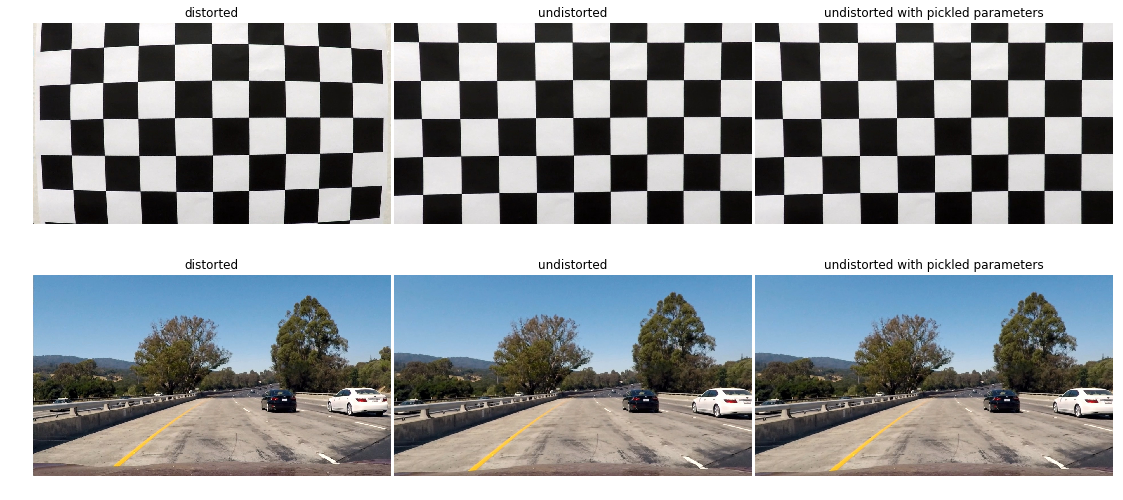

In [2]:
# Load some images 
files = [ 'camera_cal/calibration1.jpg', 'test_images/test1.jpg' ]
bgrs = [ cv2.imread(file) for file in files ]
rgbs = [ cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB) for bgr in bgrs ]

# Get the checkerboard points in 2D and 3D space from a sequence of checkerboard images 
objpoints, imgpoints = points.get()

# Compute the calibration parameters
ret, mtx, dist, rvecs, tvecs = calibrationParams.get(objpoints=objpoints, imgpoints=imgpoints, width=1280, height=720)
print('Calibration Finished')

# Create the object which can undisort images 
undistorter = Undistorter(mtx,dist)
undistorteds = [ undistorter.undistort(rgb) for rgb in rgbs ]

# OR equivalently, load the pickled calibration parmeters 
defaultUndistorter = Undistorter()
defaultUndistorteds = [ defaultUndistorter.undistort(rgb) for rgb in rgbs ]

# Show what the undistorted checkerboard looks like
fig, axs = plt.subplots(len(rgbs),3)
fig.subplots_adjust(hspace=0, wspace=0.01, bottom=0, left=0, top=1, right=1)
fig.set_size_inches(15,7)
images = [ [ rgb, undistorted, defaultUndistorted ] for rgb, undistorted, defaultUndistorted in zip(rgbs, undistorteds, defaultUndistorteds) ]
labels = [ 'distorted', 'undistorted', 'undistorted with pickled parameters' ]
for ax,imagez in zip(axs,images):
    for a,image,label in zip(ax,imagez,labels):
        a.imshow( image )
        a.axis("off")
        a.set_title(label)


## Perspective Transform

The ultimate goal is to fit polynomials to the lanes, but from the perspective above, it is hard to tell exactly how the lanes curve in the distance. Specifically, if we tried to curve-fit the lanes at this point, chances are that the curve-fit would just yield straight lines. Hence we are going to warp the perspective of the images into a top-down (birdseye) view so that we can get a better idea of how the lanes are curving. For this purpose, we will use `cv2.getPerspectiveTransform`. 

To use `cv2.getPerspectiveTransform`, we need to define 4 source and destination points (3 of which are not colinear) which define how to warp points from the source image to the destination image. We will use the four source points defined by the blue trapezoid in the following image, where the pixels within the blue trapezoid are stretched so that the upper corners are mapped to the upper corners of the warped image. 

<img width=50% src='output_images/straight_lines1_warpcoordinates.jpg'>

For example, the result of mapping the above image is:

<img width=50% src='output_images/test_images_warped/straight_lines1.jpg'>

which clearly shows that the lines are indeed straight. Applying the same transform to some other images, we get he following results:

<div><img src="test_images/straight_lines2.jpg" width=50% style="float: left;"></div>
<div><img src="output_images/test_images_warped/straight_lines2.jpg" width=50% style="float: left;"></div>
<div style="clear: both;"></div>
<div><img src="test_images/test1.jpg" width=50% style="float: left;"></div>
<div><img src="output_images/test_images_warped/test1.jpg" width=50% style="float: left;"></div>
<div style="clear: both;"></div>
<div><img src="test_images/test2.jpg" width=50% style="float: left;"></div>
<div><img src="output_images/test_images_warped/test2.jpg" width=50% style="float: left;"></div>
<div style="clear: both;"></div>
<div><img src="test_images/test3.jpg" width=50% style="float: left;"></div>
<div><img src="output_images/test_images_warped/test3.jpg" width=50% style="float: left;"></div>
<div style="clear: both;"></div>
<div><img src="test_images/test4.jpg" width=50% style="float: left;"></div>
<div><img src="output_images/test_images_warped/test4.jpg" width=50% style="float: left;"></div>
<div style="clear: both;"></div>
<div><img src="test_images/test5.jpg" width=50% style="float: left;"></div>
<div><img src="output_images/test_images_warped/test5.jpg" width=50% style="float: left;"></div>
<div style="clear: both;"></div>
<div><img src="test_images/test6.jpg" width=50% style="float: left;"></div>
<div><img src="output_images/test_images_warped/test6.jpg" width=50% style="float: left;"></div>
<div style="clear: both;"></div>

To warp images programmatically, we have defined the `Warper` class in `warper.py`. The trapezoid is defined as a hard-coded percent of width and height, where the default width and height are `width=1280` and `height=720`. If you use a different camera or change the image sizes, you will probably need to modify these values. If that occurs, then you need to choose new trapezoidal points which ensure that straight lanes are represented as straight lines after warping the images. Here is an example of how to use our `Warper` class:

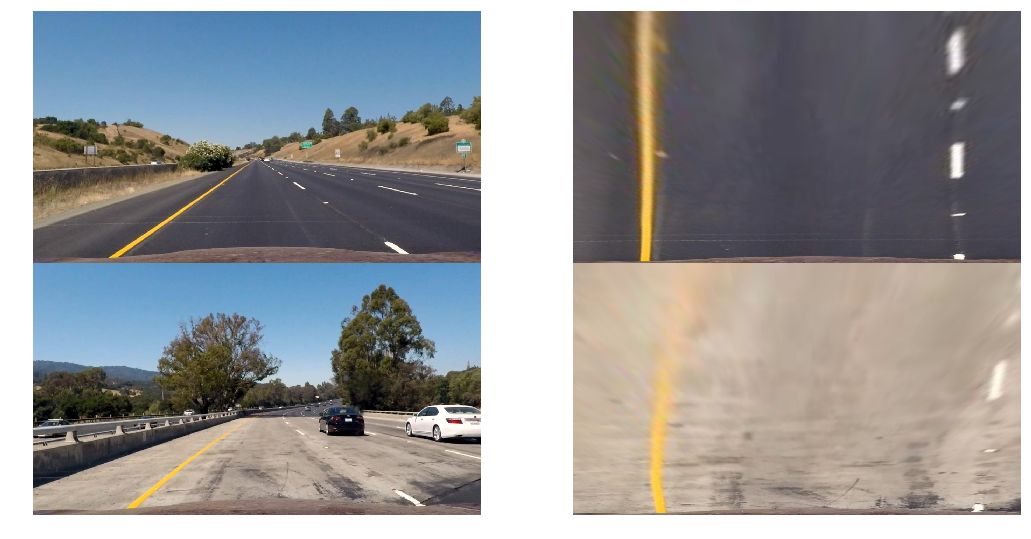

In [3]:
# Load some images 
files = [ 'output_images/test_images_undistorted/straight_lines1.jpg', 'output_images/test_images_undistorted/test1.jpg' ]
bgrs = [ cv2.imread(file) for file in files ]
rgbs = [ cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB) for bgr in bgrs ]

# Create the object which can warp an image to the desired birdseye view
warper  = Warper()
warpeds = [ warper.warp(rgb) for rgb in rgbs ]

# Show what the undistorted checkerboard looks like
fig, axs = plt.subplots(len(rgbs),2)
fig.subplots_adjust(hspace=0, wspace=0, bottom=0, left=0, top=1, right=1)
fig.set_size_inches(15,7)
images = [ [ rgb, warped ] for rgb, warped in zip(rgbs, warpeds) ]
for ax,imagez in zip(axs,images):
    for a,image in zip(ax,imagez):
        a.imshow( image )
        a.axis("off")

## Detecting Lane Pixels

The last step before actually fitting polynomials to the lanes is to figure out which pixels correspond to lane pixels. To accomplish this, there are two predominate techniques, namely: 

1. By converting the image to a colorspace in which the lanes can be easily extracted.
1. By applying an edge detection alogorithm which finds solid, continuous lines in the image. 

### Using Colorspaces
To understand what I mean by point 1), recall that pixels in images are typically represented in terms of their red, green, and blue (RGB) components (called *channels*), that is, a 1280 x 720 (width x height) image is actually represented by a 1280 x 720 x 3 array, where

1. `image[:,:,0]` is a 1280 x 720 x 1 array holding the red values of each pixel.
1. `image[:,:,1]` is a 1280 x 720 x 1 array holding the green values of each pixel.
1. `image[:,:,2]` is a 1280 x 720 x 1 array holding the blue values of each pixel.

Therefore if, in some alternate universe, lanes were painted red, then a good starting point for finding the lanes would be to look for pixels with relatively high values in ` image[:,:,0]`. 

In a similar fashion, OpenCV provides many colorspace transforms which we can use to try to make it easier to detect lanes. For instance, using OpenCV, we can convert an RGB image into an image in the HSV, HSL, LAB, and grayscale colorspaces (among others). As a first easy test, we can try converting the images into these colorspaces and seeing if thresholding the image in one of these colorspaces can help us detect lanes. For convenience, we created the method `split` in `colors.py` which splits an image into its channels, where a channel value of 0 is represented by black, and a channel value of 255 (the maximum) is represented by white. Using this function, we can easily get a quick glimpse of whether a particular colorspace looks promising: 

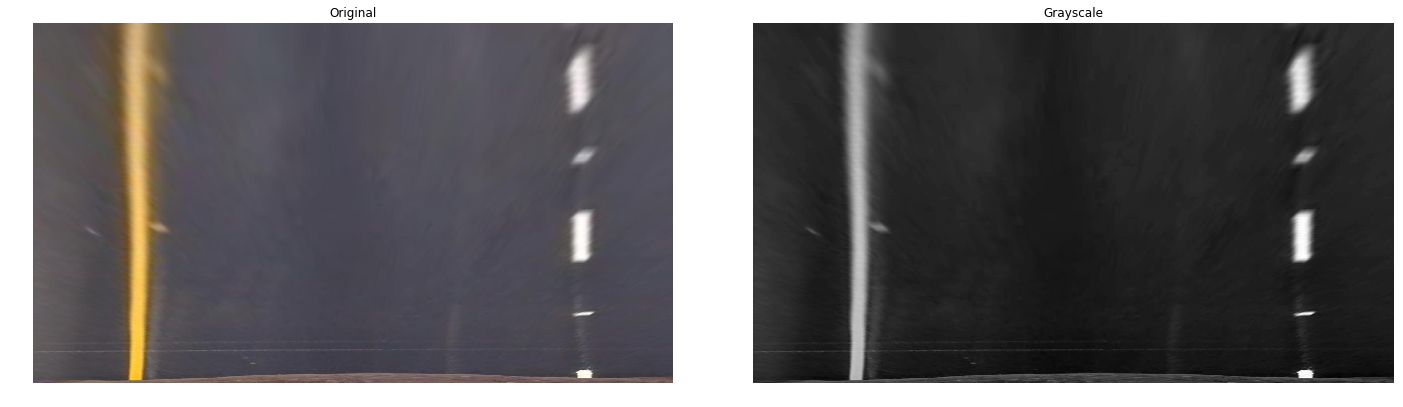

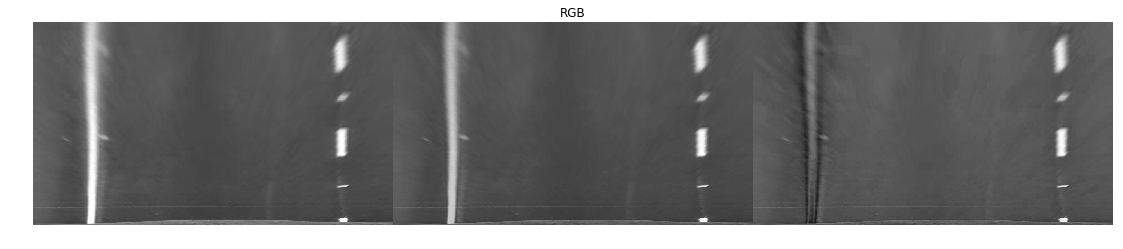

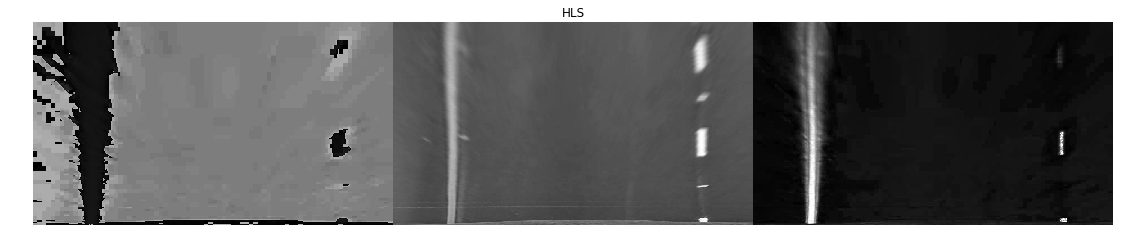

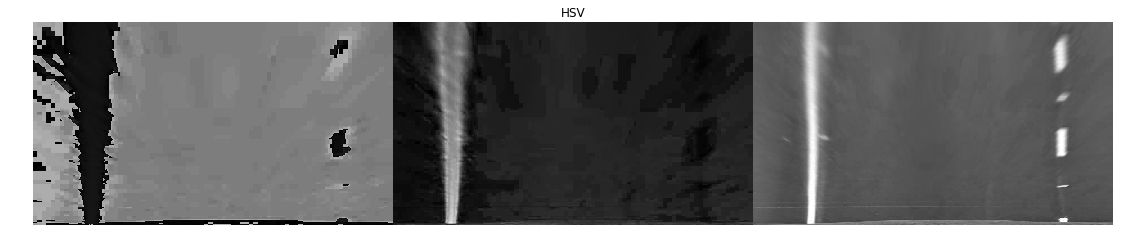

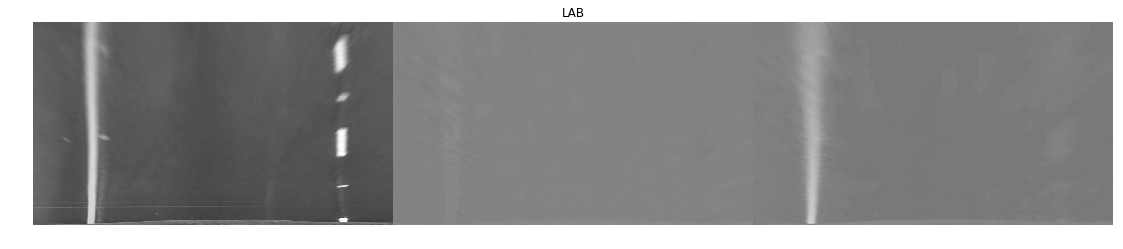

In [4]:
import cv2, colors, numpy
import matplotlib.pyplot as plt

def colorspaces( file, cspaces = 'all' ): 
    
    bgr = cv2.imread(file)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    gry = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

    # First, show the original and greyscale images
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(20,5)
    fig.subplots_adjust(hspace=0, wspace=0, bottom=0, left=0, top=1, right=1)
    ax[0].imshow(rgb) 
    ax[0].axis('off')
    ax[0].set_title('Original')
    ax[1].imshow(gry, cmap='gray') 
    ax[1].axis('off')
    ax[1].set_title('Grayscale')
    
    # Next, if cspaces = 'all', then show all of the color spaces 
    if cspaces is 'all':
        cspaces = [ 'rgb', 'hls', 'hsv', 'lab', 'sobel' ]

    # Next, show all of the other colorspaces that the user wants to see
    for cspace in cspaces:
        cspace = cspace.lower()
        if cspace == 'rgb': 
            colors.split(rgb, horizontal=True, title="RGB")
        elif cspace == 'hls': 
            hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)
            colors.split(hls, horizontal=True, title="HLS")
        elif cspace == 'hsv': 
            hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
            colors.split(hsv, horizontal=True, title="HSV")
        elif cspace == 'lab': 
            lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
            colors.split(lab, horizontal=True, title="LAB")
        elif cspace == 'sobel':
            sabs = numpy.absolute(cv2.Sobel(gry, cv2.CV_64F, 1, 0, ksize=7))
            sobelX = numpy.uint8(255 * sabs / numpy.max(sabs))
            sabs = numpy.absolute(cv2.Sobel(gry, cv2.CV_64F, 0, 1, ksize=7))
            sobelY = numpy.uint8(255 * sabs / numpy.max(sabs))
            sabs = numpy.sqrt(sobelX ** 2 + sobelY ** 2)
            sobelXY = numpy.uint8(255 * sabs / numpy.max(sabs))
            sobel = numpy.zeros_like( rgb )
            sobel[:,:,0] = sobelX
            sobel[:,:,1] = sobelY
            sobel[:,:,2] = sobelXY
            colors.split(sobel, horizontal=True, title="Sobel (x,y,norm)")
        else: 
            print('Unsupported colorspace:', cspace )

colorspaces('output_images/test_images_warped/straight_lines1.jpg', cspaces = ['rgb','hls','hsv','lab'])

Some comments are in order here:

1. The only noticeable difference between the RGB channels seems to be that the left (yellow) lane has a blue value of approximately zero (denoted by black), while the red and green channels are relatively high value (denoted by white). Perhaps we could try to detect yellow lanes by searching for pixels with low blue-values. 

1. The lanes tend to be relatively bright with respect to the background, that is, they tend to have a high greyscale value. In HLS this corresponds to a high L-value, in HSV this corresponds to a high V-value, and in LAB this corresponds to a high L-value. So using brightness may be a way to help detect lanes. However, since the HSV and LAB channels are basically doing the same thing as grayscale, we will not use those colorspaces.

1. The S-channel in the HLS image seems to be highlighting both lanes, and is not dependent on the brightness of the image (although this is not immediately apparent from the above image).

1. None of the other channels seem to be obviously useful. 

You might think we can stop here and call it a day, but let's break down another image and see how it looks in these colorspaces. Specifically, let's examine a frame from one of the videos:

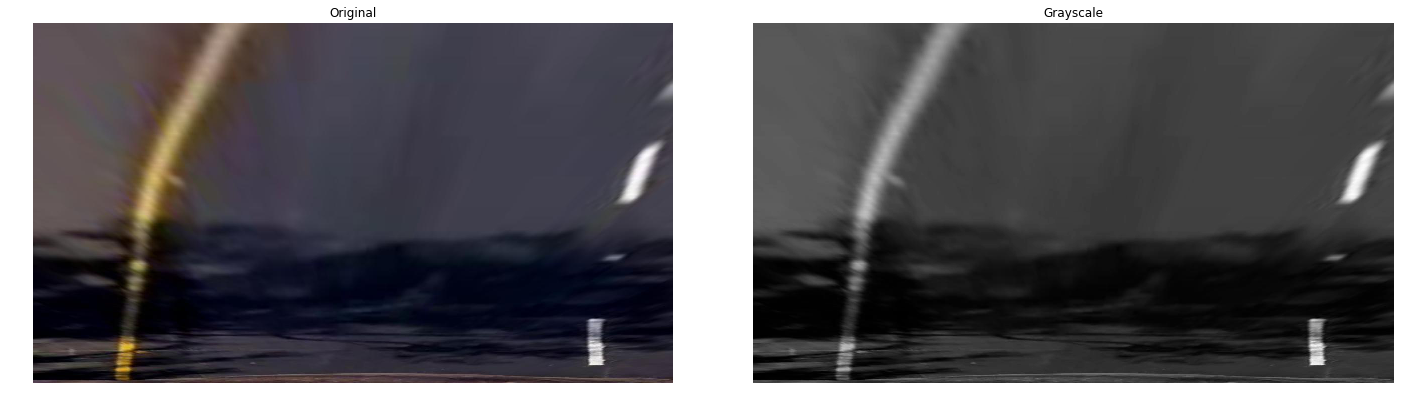

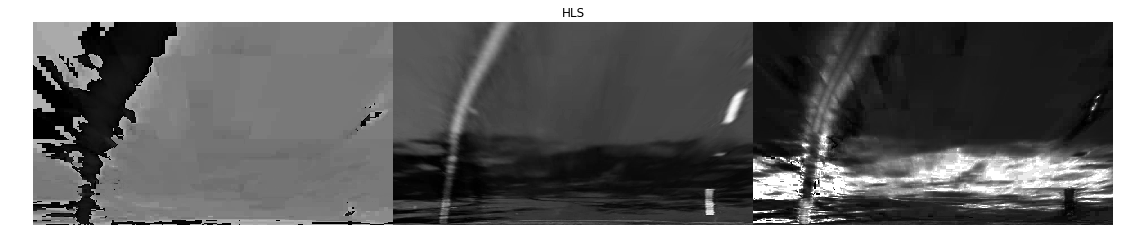

In [5]:
colorspaces('output_images/project_video_warped/frame1044.jpg', cspaces = ['hls'])

Contrary to the previous image, the S-channel of the HLS colorspace does horrible for this image. Specifically, it seems like we the S-channel is erroneously high in the dark pixels produced by the shade of the tree. We will address this later. 

### Edge Detection with Sobel Filters

Sobel filters differentiate an image so that we can see the color gradient in an image in a particular direction. For instance, we can apply Sobel filters in the x- and y-directions, or compute the norm of these derivatives. Let's see wat happens when we apply Sobel filters to the previous image:

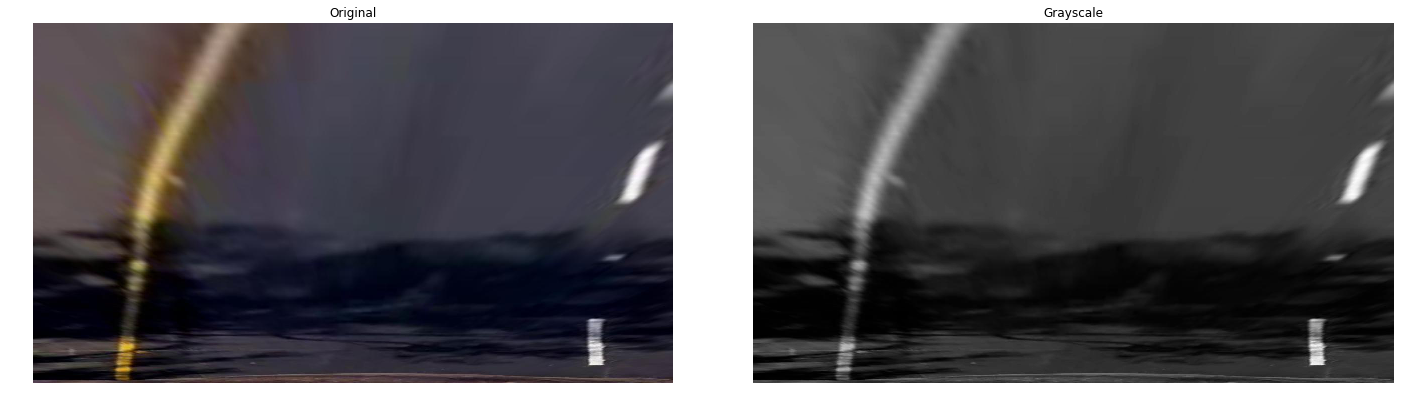

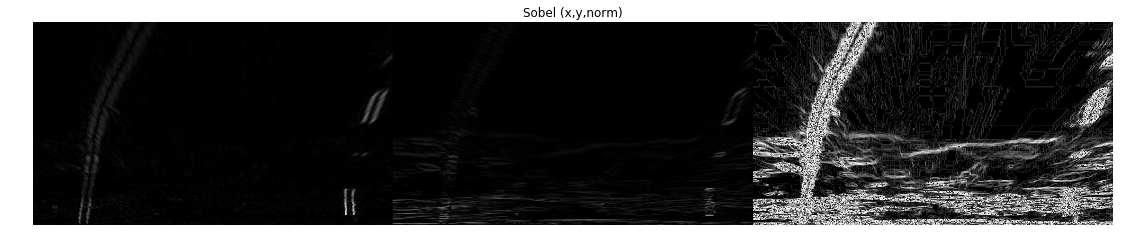

In [6]:
colorspaces('output_images/project_video_warped/frame1044.jpg', cspaces = ['sobel'])

Here we can see that although it is a little bit dark, the Sobel X filter seems to be capturing both lanes with very little noise. Let's try another image just to make sure we are not drawing erroneous conclusions: 

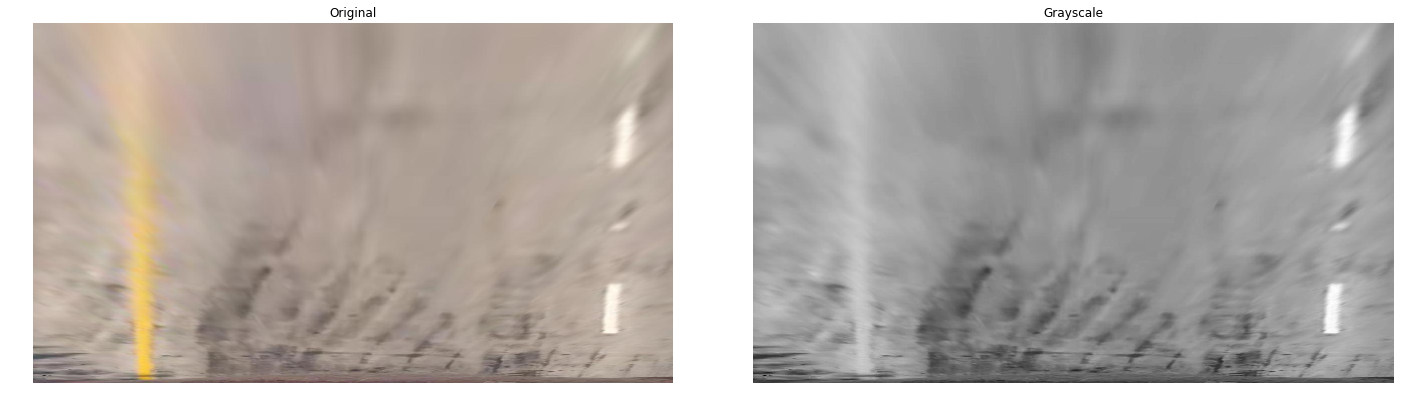

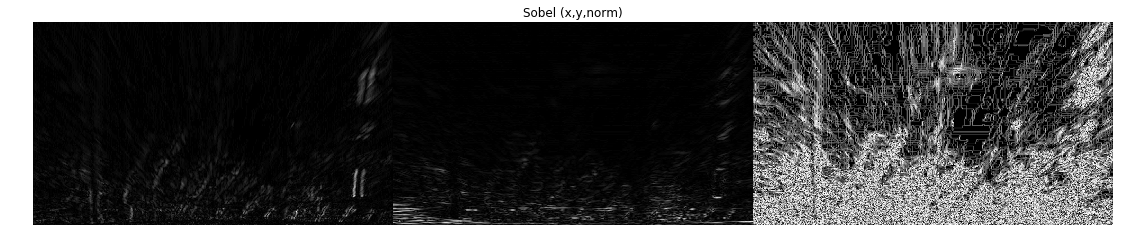

In [7]:
colorspaces('output_images/project_video_warped/frame558.jpg', cspaces = ['sobel'])

Sure enough, looking at this new image, we see a lot of noise starting to creep in. However, just like with the S-channel results, this noise tends to occur at the dark pixels. So maybe we are on to something. 

### Putting it all together

We have seen some images where the S-channel of the HLS colorspace does a good job of detecting lane pixels and some images where the X-axis Sobel filter does a good job of detecting lane pixels. However, for both methods, we have found images where dark pixels appear to be producing erroneous results. Therefore we are going to try to apply the following technique: 

We are going to look for pixels with high S-channel OR high Sobel X values, AND a high grayscale value. 

There is one catch though... we cannot simply threshold the grayscale values in the absolute sense because then poorly eluminated images would always fall below the threshold (even for the lane pixels), and highly illuminated photos would never get cut off. So what we are going to do is to only consider pixels in the greyscale image in the upper 50th percentile of brightness as potential lane pixels. Programmatically, our final filter will look like this:

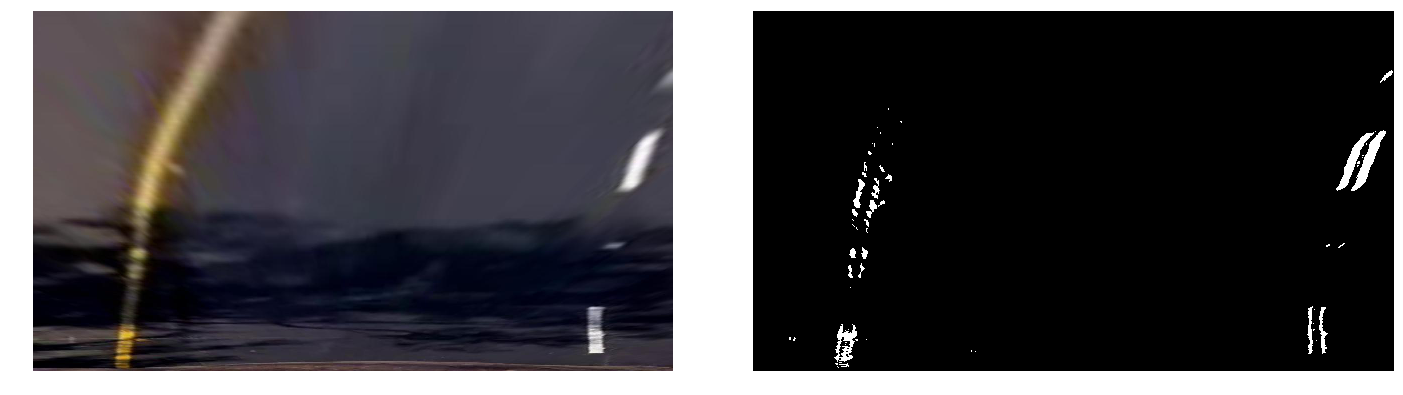

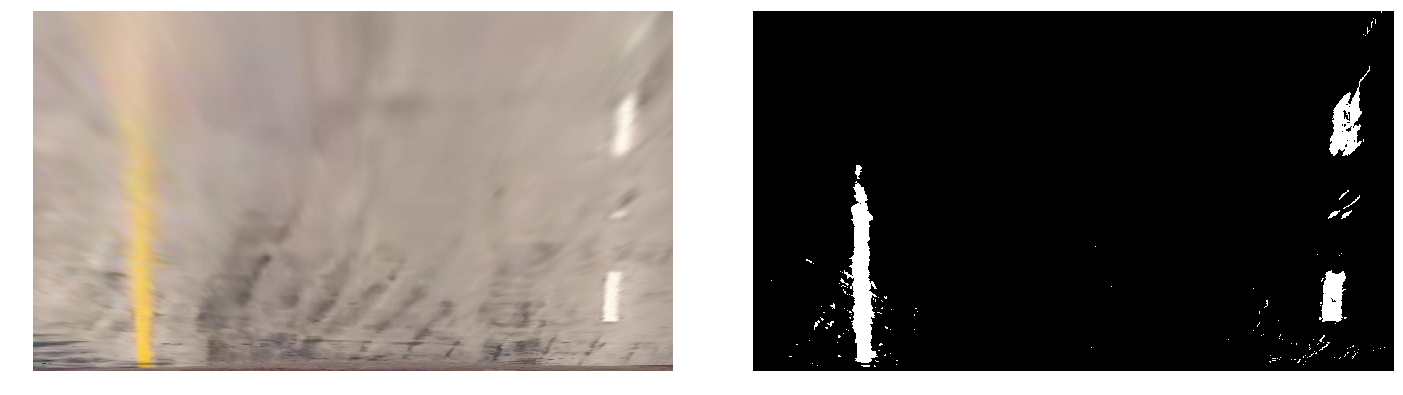

In [8]:
def laneDetector(file):
    
    bgr = cv2.imread(file)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    
    # Only consider pixels with a grayscale value in the upper 50th percentile
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    potentialLanePixels = gray >= numpy.percentile(gray, 50)

    # Among those pixels, consider any pixels which have a relatively large Sobel X or S-channel vlaue
    sabs = numpy.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=7))
    sobelX = numpy.uint8(255 * sabs / numpy.max(sabs))
    potentialSobel = sobelX > 30

    S = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)[:, :, 2]
    potentialS = S > 150

    potentialLanePixels = potentialLanePixels & ( potentialSobel | potentialS )
    
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(20,5)
    fig.subplots_adjust(hspace=0, wspace=0, bottom=0, left=0, top=1, right=1)
    ax[0].imshow(rgb) 
    ax[0].axis('off')
    ax[1].imshow(potentialLanePixels, cmap='gray') 
    ax[1].axis('off')
    
laneDetector('output_images/project_video_warped/frame1044.jpg')
laneDetector('output_images/project_video_warped/frame558.jpg')

Not too shabby... 

## Lane Fitting 

At this point, we have detected which pixels are potential lane pixels. This process is not, and does not have to be perfect. We are going to fit 2nd order polynomials to the left and right hand lanes, so of course we expect there going to be outliers. The process of fitting lanes actually turns out to be surprisingly simple... 

1. We split the image in half, and assume that pixels in the left half belong to the left lane, and pixels in the right half belong to the right lane. 

1. We define our axes so that the origin of the coordinate system is in the bottom left hand corner of the image. The advantage of this parameterization is that when we define a polynomial (e.g. f(y) = ay^2 + by + c), the last coefficient *c* defines the point where the lane intercepts the bottom of the image. 

1. We assume that the lanes have the same curvature. This means that the only difference between the left and right hand lane polynomials is the last coefficient (which defines the intercept). Specifically, we assume that the left-hand lane is of the form f(y) = ay^2 + by + c, and the right-hand lane is of the form g(y) = ay^2 + by + (c+d). Hence there are only four parameters that we need to optimize. 

1. To help constrain the results, we enforce the constraint that the lane width is between 60% and 80% of the image width, and that the intercept of the left hand lane is between 0% and 50% of the image width. 

1. To optimize the results, we use the `scipy.optimize.least_squares` function with a `soft_l1` regressor. The reason use should not use the standard least-squares loss is that it tends to weight outliers too heavily. (Believe me... I tried it, and it performs horribly.)

For convenience, we have have put this all together in the `LaneFinder` class of `lanes.py`, whose `find` method takes in an RGB image, and returns the same image with the lanes overlayed. The following code shows how to use this class (note that we are using the default `Undistorter` and `Warper`, but you can change those if desired):  

Using default camera calibration parameters with width=1280,height=720
Loading pickled calibration parameters


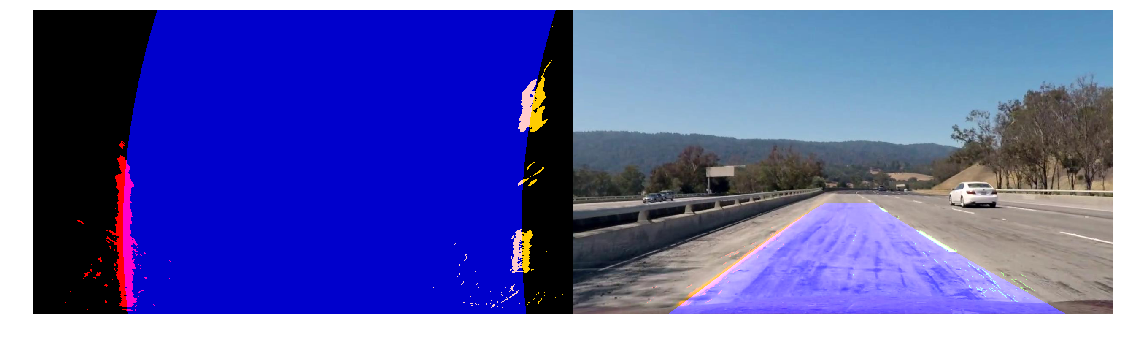

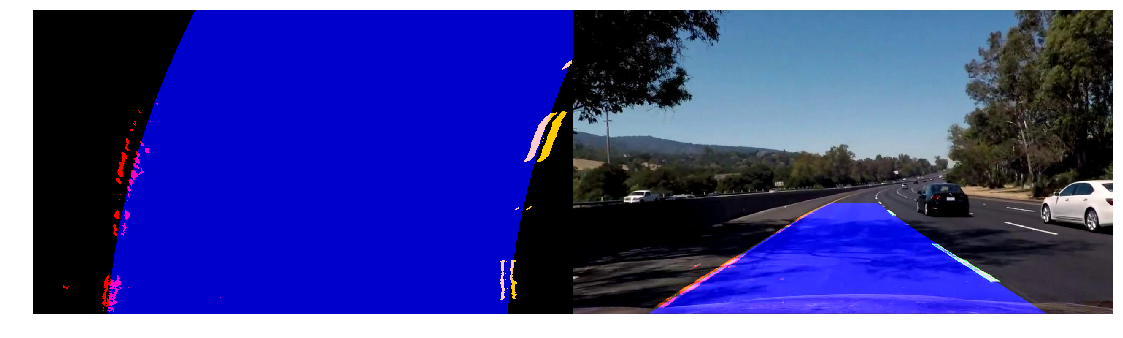

In [1]:
import cv2
from lanes import LaneFinder

files = [ 'project_video/frame558.jpg', 
          'project_video/frame1044.jpg' ]
laneFinder = LaneFinder() 
for file in files:
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    laneFinder.find(image, display=True)

Running this over the whole video yields the following results:

<video width="100%" controls src="output_videos/project_video.mp4" />